In [6]:
import src
import numpy as np
import argparse
import copy
import logging
import random
import torch
from box import Box
from pathlib import Path
from shutil import copyfile
from matplotlib import pyplot as plt

In [2]:
def _get_instance(module, config, *args):

    cls = getattr(module, config.name)
    return cls(*args, **config.get('kwargs', {}))

In [3]:
config = Box.from_yaml(filename='/home/tony/Incremental_Learning/configs/train/icarl_config.yaml')
saved_dir = Path(config.main.saved_dir)
if not saved_dir.is_dir():
    saved_dir.mkdir(parents=True)

random_seed = config.main.get('random_seed')
if random_seed is None:
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
else:
    logging.info('Make the experiment results deterministic.')
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

logging.info('Create the device.')
if 'cuda' in config.trainer.kwargs.device and not torch.cuda.is_available():
    raise ValueError("The cuda is not available. Please set the device to 'cpu'.")
device = torch.device(config.trainer.kwargs.device)

logging.info('Create the network architecture.')
config.net.setdefault('kwargs', {}).update(device=device)
net = _get_instance(src.model.nets, config.net).to(device)

logging.info('Create the loss functions and corresponding weights.')
loss_fns, loss_weights = [], []
defaulted_loss_fns = [loss_fn for loss_fn in dir(torch.nn) if 'Loss' in loss_fn]
for config_loss in config.losses:
    if config_loss.name in defaulted_loss_fns:
        loss_fn = _get_instance(torch.nn, config_loss)
    else:
        loss_fn = _get_instance(src.model.losses, config_loss)
    loss_fns.append(loss_fn)
    loss_weights.append(config_loss.weight)

logging.info('Create the metric functions.')
metric_fns = [_get_instance(src.model.metrics, config_metric) for config_metric in config.metrics]

logging.info('Create the learner.')
kwargs = {
    'config': config,
    'saved_dir': saved_dir,
    'device': device,
    'net': net,
    'loss_fns': loss_fns,
    'loss_weights': loss_weights,
    'metric_fns': metric_fns,
}
config.learner.kwargs.update(kwargs)

learner = _get_instance(src.learner, config.learner)

In [9]:
imgs = []
# learner.current_task += 1
dataset = learner.build_dataset(learner.config, learner.current_task, learner.class_per_task)
loader = learner.build_dataloader(learner.config, dataset, 'train')
print(len(loader))
count = np.zeros(100)
for data in loader:
    for i in range(data['targets'].size(0)):
        gt = data['targets'][i, 0]
        if gt==3:
            imgs.append(data['inputs'][i])
        count[gt] += 1
print(count)
loader = learner.build_dataloader(learner.config, dataset, 'valid')
print(len(loader))
count = np.zeros(100)
for data in loader:
    for i in range(data['targets'].size(0)):
        gt = data['targets'][i, 0]
        count[gt] += 1
print(count)

36
[450. 450. 450. 450. 450. 450. 450. 450. 450. 450.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
4
[50. 50. 50. 50. 50. 50. 50. 50. 50. 50.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


torch.Size([3, 32, 32])


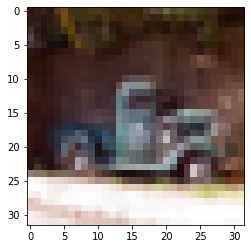

In [10]:
img = imgs[3]
print(img.size())
img = img.permute(1, 2, 0).contiguous()
plt.imshow(img.long())

torch.Size([3, 32, 32])


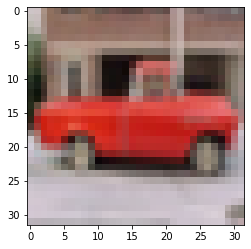

In [11]:
img = imgs[10]
print(img.size())
img = img.permute(1, 2, 0).contiguous()
plt.imshow(img.long())

torch.Size([3, 32, 32])


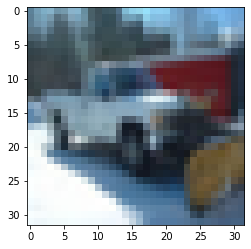

In [12]:
img = imgs[13]
print(img.size())
img = img.permute(1, 2, 0).contiguous()
plt.imshow(img.long())

In [26]:
loader = learner.build_dataloader(learner.config, dataset, 'test')
print(len(loader))
count = np.zeros(100)
for data in loader:
    for i in range(data['targets'].size(0)):
        gt = data['targets'][i, 0]
        count[gt] += 1
print(count)

79
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100.]
